In [1]:
# connect to google drive
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH, force_remount = True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/ProgettoAI/ProgettoAI/SteRoom

/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/SteRoom


### Importing Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.9.2


### Seed

In [4]:
seed = 1926
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Loading Image Dataset

In [5]:
data_dir = '/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/Processed_dataset'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [6]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3
batch_size = 32

In [7]:
# DenseNet preprocessing function
from tensorflow.keras.applications.densenet import preprocess_input as preprocessing
preprocessing

<function keras.applications.densenet.preprocess_input(x, data_format=None)>

In [8]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(preprocessing_function = preprocessing)

training_set = datagen.flow_from_directory(
        directory = training_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

validation_set = datagen.flow_from_directory(
        directory = validation_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


### Import Frozen Model

In [9]:
frozen_tl_model = tfk.models.load_model('densenet121_frozen')
frozen_tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 gap (GlobalAveragePooling2D  (None, 1024)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

### Fine Tuning

In [10]:
# Set all EfficientNetB3 layers to True
frozen_tl_model .get_layer('densenet121').trainable = True

In [11]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(frozen_tl_model.get_layer('densenet121').layers):
  layer.trainable = True
for i, layer in enumerate(frozen_tl_model.get_layer('densenet121').layers):
   print(i, layer.name, layer.trainable)
frozen_tl_model.summary()

0 input_1 True
1 zero_padding2d True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_1 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn True
3

In [12]:
finetuned_model = frozen_tl_model
finetuned_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(10**-5), metrics='accuracy')
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 gap (GlobalAveragePooling2D  (None, 1024)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

### Model Training

In [13]:
# Callback
learningrate = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-8)

In [14]:
# Train the model
history = finetuned_model.fit(
    x = training_set,
    epochs = 30,
    validation_data = validation_set,
    callbacks = learningrate
).history

Epoch 1/30
339/339 [==============================] - 4664s 14s/step - loss: 0.8811 - accuracy: 0.7574 - val_loss: 0.3570 - val_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 2/30
339/339 [==============================] - 164s 483ms/step - loss: 0.3978 - accuracy: 0.8622 - val_loss: 0.2225 - val_accuracy: 0.9076 - lr: 1.0000e-05
Epoch 3/30
339/339 [==============================] - 167s 493ms/step - loss: 0.2933 - accuracy: 0.8922 - val_loss: 0.1962 - val_accuracy: 0.9188 - lr: 1.0000e-05
Epoch 4/30
339/339 [==============================] - 166s 490ms/step - loss: 0.2396 - accuracy: 0.9078 - val_loss: 0.1717 - val_accuracy: 0.9321 - lr: 1.0000e-05
Epoch 5/30
339/339 [==============================] - 167s 494ms/step - loss: 0.1971 - accuracy: 0.9233 - val_loss: 0.1628 - val_accuracy: 0.9377 - lr: 1.0000e-05
Epoch 6/30
339/339 [==============================] - 167s 491ms/step - loss: 0.1625 - accuracy: 0.9347 - val_loss: 0.1550 - val_accuracy: 0.9394 - lr: 1.0000e-05
Epoch 7/30
339/339 [===

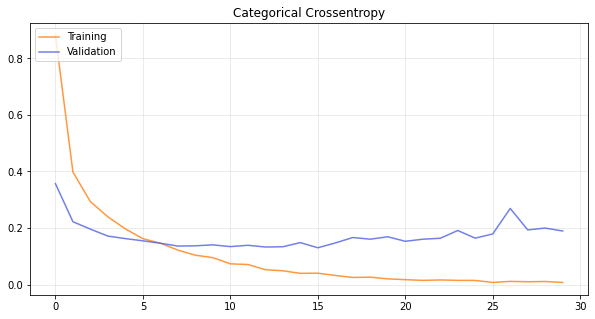

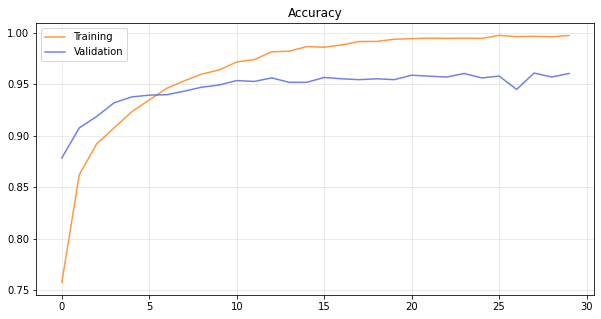

In [16]:
# Plot the training

# Loss Function
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

### Predictions Evaluation

In [9]:
model = tfk.models.load_model('densenet121_finetuning_all')

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 gap (GlobalAveragePooling2D  (None, 1024)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [10]:
labels = ['N', 'P', 'T']

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits = 4))

In [12]:
y_val = validation_set.labels
y_test = test_set.labels

In [13]:
val_predictions = model.predict(validation_set)
test_predictions = model.predict(test_set)

73/73 [==============================] - 480s 7s/step


              precision    recall  f1-score   support

           0     0.9703    0.9662    0.9682      1420
           1     0.9675    0.9843    0.9758       635
           2     0.8914    0.8750    0.8831       272

    accuracy                         0.9605      2327
   macro avg     0.9431    0.9418    0.9424      2327
weighted avg     0.9603    0.9605    0.9604      2327



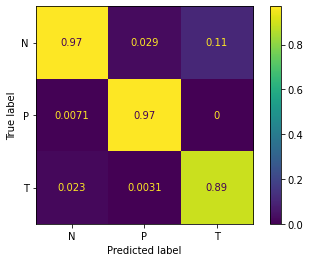

In [21]:
# Validation
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

              precision    recall  f1-score   support

           0     0.9538    0.9792    0.9663      1392
           1     0.9779    0.9779    0.9779       634
           2     0.9350    0.8127    0.8696       283

    accuracy                         0.9584      2309
   macro avg     0.9556    0.9233    0.9379      2309
weighted avg     0.9581    0.9584    0.9576      2309



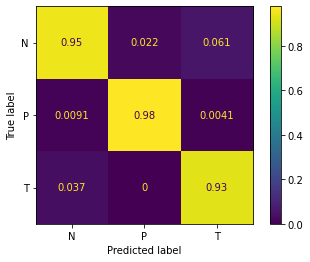

In [22]:
# Test
print_evaluation(y_test, np.argmax(test_predictions, axis=-1))

### Save Model

In [15]:
finetuned_model.save('densenet121_finetuning_all')